In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.callbacks import ModelCheckpoint

import skimage.io
from selective_search import selective_search, box_filter
from nms import nms

import os
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import json
import random
import tqdm

In [253]:
PATH = "/mnt/d/personal/cotton/Annoted_boll_burst_2019_trial"

PATH = "/mnt/d/personal/cotton/samples/dset_rand/"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'test')
train_cats_dir = os.path.join(train_dir, 'positive')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'negative')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'positive')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'negative')  # directory with our validation dog pictures
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)


def read_all_images(pth):
    imgs = []
    for fl in os.listdir(pth):
        imgs.append(cv2.imread(path.join(pth, fl)))
    return np.array(imgs)

X_1 = read_all_images(train_cats_dir)
Y_1 = np.ones(X_1.shape[0])
X_2 = read_all_images(train_dogs_dir)
Y_2 = np.zeros(X_2.shape[0])
X = np.concatenate((X_1, X_2))
Y = to_categorical(np.concatenate((Y_1, Y_2)))
X_1 = read_all_images(validation_cats_dir)
Y_1 = np.ones(X_1.shape[0])
X_2 = read_all_images(validation_dogs_dir)
Y_2 = np.zeros(X_2.shape[0])
XX = np.concatenate((X_1, X_2))
YY = to_categorical(np.concatenate((Y_1, Y_2)))

In [13]:
batch_size = 128
epochs = 30
IMG_HEIGHT = 40
IMG_WIDTH = 40

In [210]:
train_image_generator = ImageDataGenerator(rescale=1./255,
#                                           shear_range=0.2,
#                                           vertical_flip=True,
#                                           horizontal_flip=True,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2
                                          ) # Generator for our training data

# train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
# train_image_generator = ImageDataGenerator() # Generator for our training data
# validation_image_generator = ImageDataGenerator() # Generator for our validation data

train_data_gen = train_image_generator.flow(X, Y, shuffle=True, batch_size=batch_size)
# val_data_gen = validation_image_generator.flow(XT, YT, batch_size=batch_size)
total_train = len(X)
print(len(X))
# total_val = len(XT)

194380


train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(units=2, activation="softmax")
])

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(units=2, activation="softmax")
])


# VGGNET
model = Sequential()
model.add(Conv2D(input_shape=(40,40,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [63]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(30, 30, 3)))
model.add(Conv2D(64, 3,activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, 3, activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, 3, activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, 3, activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Conv2D(512, 3, activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [211]:
import tensorflow.keras.applications.mobilenet as mn
model = mn.MobileNet(input_shape=(40, 40, 3), classes=2, weights=None)

In [212]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [113]:
model.load_weights("mn-09.hdf5")

In [34]:
filepath="mn-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath,verbose=1)

In [214]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
#     steps_per_epoch = 2,
#     epochs=epochs
    epochs=10,
    callbacks=[checkpoint],
    class_weight={0:1, 1: 10}
    
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
Train for 1518 steps
Epoch 1/10
1517/1518 [============================>.] - ETA: 0s - loss: 0.0828 - accuracy: 0.9807
Epoch 00001: saving model to mn-01.hdf5
1518/1518 [==============================] - 1058s 697ms/step - loss: 0.0828 - accuracy: 0.9807
Epoch 2/10
1517/1518 [============================>.] - ETA: 0s - loss: 0.0771 - accuracy: 0.9821
Epoch 00002: saving model to mn-02.hdf5
1518/1518 [==============================] - 1022s 673ms/step - loss: 0.0771 - accuracy: 0.9821
Epoch 3/10
1517/1518 [============================>.] - ETA: 0s - loss: 0.0747 - accuracy: 0.9825
Epoch 00003: saving model to mn-03.hdf5
1518/1518 [==============================] - 1066s 703ms/step - loss: 0.0747 - accuracy: 0.9825
Epoch 4/10
1517/1518 [============================>.] - ETA: 0s - loss: 0.0702 - accuracy: 0.9836
Epoch 00004: saving model to mn-04.hdf5
1518/1518 [==============================] - 1036s 682ms/step - loss: 0.0701 - accuracy: 0.9836
Epoch 5/10
1517/15

In [233]:
model.load_weights("mn-08.hdf5")

In [208]:
model.save_weights("mn_jan_v2.h5")

for layer in model.layers:
    print(layer.name)
    layer.trainable = True
    print(layer.trainable)

model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True


history = model.fit(
    X, Y,
    epochs=30,
    validation_split=0.2, shuffle=True, class_weight={0: 100, 1: 1})

history = model.fit(
    XX, YY,
    epochs=30,
    validation_split=0.2, shuffle=True, class_weight={0: 1, 1: 1})

model.save_weights("temp.h5")

model.load_weights("temp.h5")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


image = val_data_gen.next()

image = train_data_gen.next()

print(image[0].shape)
predictions = model.predict_classes(image[0])

print(confusion_matrix(np.argmax(image[1], axis=1), predictions.flatten()))
print(classification_report(np.argmax(image[1], axis=1), predictions.flatten()))

model.save(path.join(PATH, "model.h5"))

ann = pd.read_csv(path.join(PATH, "samples", "via_export_csv.csv"))
print(ann.head())
print(ann[ann.region_count > 0].filename.unique().size)

grp = ann.groupby("filename")
print(grp.mean())

In [244]:
# Runs the model through the sample images and draws a bounding box
do_nms = True
do_prediction = True
prob_thresh = 0.9
stride = 25
width = 50
prediction_width = 40
do_resize = True
base_path = path.join(PATH, "split")
ann = pd.read_csv(path.join(base_path, "via_export_csv.csv"))
for file in ann["filename"].unique():
    cnt = 0
#     if file not in ["2019_1206_122956_179.JPG", "2019_1206_122957_180.JPG"]:
#         continue
    if not file.startswith("2019_1206_122956_179_3_4"):
        continue
    sample_ann = ann[ann["filename"] == file]
    training_data = []
    img = cv2.imread(path.join(base_path, file))
    for _x in range(0, img.shape[1] - width, stride):
        for _y in range(0, img.shape[0] - width, stride):
            xstart = _x
            xend = _x + width
            ystart = _y
            yend = _y + width
            training_data.append([ystart, yend, xstart, xend])
    
    img = cv2.imread(path.join(base_path, file))
    if do_prediction:
        all_images = []
        predictions = []
        for ix in tqdm.tqdm_notebook(range(len(training_data))):
            val = training_data[ix]
            samp_img = img[val[0]: val[1], val[2]: val[3]]
            if do_resize:
                samp_img = cv2.resize(samp_img, (prediction_width, prediction_width))
            all_images.append(samp_img)
            if len(all_images) == 50000:
                all_images = np.array(all_images) * 1.0 / 255
                temp_predictions = model.predict(all_images, verbose=1).tolist()
                predictions.extend(temp_predictions)
                all_images = []
        all_images = np.array(all_images) * 1.0 / 255
        predictions.extend(model.predict(all_images, verbose =1).tolist())

    img = cv2.imread(path.join(base_path, "labels", file))
    all_boxes = []
    all_scores = []
    for ix in range(len(predictions)):
        prob = predictions[ix][1]
        if prob > 0.5:
            val = training_data[ix]
            all_boxes.append([val[2], val[0], width, width])
            all_scores.append(prob)
    if do_nms:
        indices = nms.boxes(all_boxes, all_scores, nms_threshold=0.1)
    else:
        indices = range(len(all_boxes))
     
    for ix in indices:
        if all_scores[ix] > prob_thresh:
            cnt += 1
            img = cv2.rectangle(img, (all_boxes[ix][0], all_boxes[ix][1]), (all_boxes[ix][0] + width, all_boxes[ix][1] + width), (0, 255, 0), 2)
    cv2.imwrite(path.join(base_path, "predictions", file), img)
    print(cnt)

/home/suba/.virtualenvs/emotion/lib/python3.6/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



140/140 [==============================] - 0s 715us/sample
12


In [258]:
# Runs the model through the sample images and draws a bounding box
do_nms = True
do_prediction = True
prob_thresh = 0.99
stride = 30
width = 60
prediction_width = 40
do_resize = True
base_path = path.join(PATH, "Set2")
ann = pd.read_csv(path.join(base_path, "via_export_csv.csv"))
for file in ann["filename"].unique():
    cnt = 0
#     if file not in ["2019_1206_122956_179_3_4.jpg", "2019_1206_122956_179_3_3.jpg", "2019_1206_122956_179_8_3.jpg",
#                    "2019_1206_122956_179_6_2.jpg"]:
#         continue
#     if not file.startswith("2019_1206_122954_178"):
#         continue
    sample_ann = ann[ann["filename"] == file]
    training_data = []
    img = cv2.imread(path.join(base_path, file))
    widths = [width - 20, width - 10, width, width + 10, width + 20]
    for w in widths:
        for h in widths:
            stridew = int(w/2)
            strideh = int(h/2)
            for _x in range(0, img.shape[1] - w, stridew):
                for _y in range(0, img.shape[0] - h, strideh):
                    xstart = _x
                    xend = _x + width
                    ystart = _y
                    yend = _y + width
                    training_data.append([ystart, yend, xstart, xend])
    
    img = cv2.imread(path.join(base_path, file))
    if do_prediction:
        all_images = []
        predictions = []
        for ix in tqdm.tqdm_notebook(range(len(training_data))):
            val = training_data[ix]
            samp_img = img[val[0]: val[1], val[2]: val[3]]
            if do_resize:
                samp_img = cv2.resize(samp_img, (prediction_width, prediction_width))
            all_images.append(samp_img)
            if len(all_images) == 50000:
                all_images = np.array(all_images) * 1.0 / 255
                temp_predictions = model.predict(all_images, verbose=1).tolist()
                predictions.extend(temp_predictions)
                all_images = []
        all_images = np.array(all_images) * 1.0 / 255
        predictions.extend(model.predict(all_images, verbose =1).tolist())

    img = cv2.imread(path.join(base_path, "labels", file))
    all_boxes = []
    all_scores = []
    for ix in range(len(predictions)):
        prob = predictions[ix][1]
        if prob > 0.5:
            val = training_data[ix]
            all_boxes.append([val[2], val[0], width, width])
            all_scores.append(prob)
    if do_nms:
        indices = nms.boxes(all_boxes, all_scores, nms_threshold=0.1)
    else:
        indices = range(len(all_boxes))
     
    for ix in indices:
        if all_scores[ix] > prob_thresh:
            cnt += 1
            img = cv2.rectangle(img, (all_boxes[ix][0], all_boxes[ix][1]), (all_boxes[ix][0] + width, all_boxes[ix][1] + width), (0, 255, 0), 2)
    cv2.imwrite(path.join(base_path, "predictions", file), img)
    print(cnt)

/home/suba/.virtualenvs/emotion/lib/python3.6/site-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


50000/50000 [==============================] - 30s 591us/sample

14179/14179 [==============================] - 8s 595us/sample
417


50000/50000 [==============================] - 32s 649us/sample

14179/14179 [==============================] - 9s 640us/sample
497


50000/50000 [==============================] - 32s 645us/sample

14179/14179 [==============================] - 9s 632us/sample
453


50000/50000 [==============================] - 35s 692us/sample

14179/14179 [==============================] - 9s 639us/sample
441


50000/50000 [==============================] - 31s 613us/sample

14179/14179 [==============================] - 8s 594us/sample
363


50000/50000 [==============================] - 31s 621us/sample

14179/14179 [==============================] - 9s 668us/sample
352


50000/50000 [==============================] - 31s 622us/sample

14179/14179 [==============================] - 10s 692us/sample
378


50000/50000 [==============================] - 32s 636us/sample

14179/14179 [==============================] - 9s 622us/sample
334


50000/50000 [==============================] - 32s 634us/sample

14179/14179 [==============================] - 9s 624us/sample
337


50000/50000 [==============================] - 39s 787us/sample

14179/14179 [==============================] - 9s 619us/sample
356


In [218]:
predictions

[[0.999998927116394, 1.0273620318912435e-06],
 [0.9999948740005493, 5.125348707224475e-06],
 [0.9999912977218628, 8.733434697205666e-06],
 [0.999976396560669, 2.364775355090387e-05],
 [0.9999991655349731, 8.51351103392517e-07],
 [0.9999991655349731, 8.226190857385518e-07],
 [0.9999992847442627, 7.218312134682492e-07],
 [0.9999988079071045, 1.237756237060239e-06],
 [0.9999985694885254, 1.3760630963588483e-06],
 [0.9999985694885254, 1.4730513839822379e-06],
 [0.9999986886978149, 1.3324040537554538e-06],
 [0.9999986886978149, 1.3554413271776866e-06],
 [0.9999990463256836, 9.257672104467929e-07],
 [0.9999992847442627, 7.035993121462525e-07],
 [0.999998927116394, 1.0843243671843084e-06],
 [0.9999985694885254, 1.4032702893018723e-06],
 [0.9999988079071045, 1.2148790347055183e-06],
 [0.9999992847442627, 6.980885700613726e-07],
 [0.9999990463256836, 9.086668910640583e-07],
 [0.9999991655349731, 8.277697816083673e-07],
 [0.9999992847442627, 6.864684678475896e-07],
 [0.9999939203262329, 6.104091

In [123]:
all_scores

[]

In [118]:
Y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [44]:
samp_img.shape

(40, 40, 3)

In [45]:
np.resize(samp_img, (50, 50, 3)).shape

(50, 50, 3)

# Trying out selective search

img = cv2.imread(path.join(base_path, file))
image = skimage.io.imread(path.join(base_path, file))
boxes = selective_search(image, mode='fast', random=False)
predictions = []
all_images = []
for ix in boxes:
    samp_img = img[ix[1]: ix[3], ix[0]: ix[2]]
    all_images.append(cv2.resize(samp_img, (40, 40)))
all_images = np.array(all_images) * 1.0 / 255
predictions.extend(model.predict_proba(all_images, verbose =1).tolist())
img = cv2.imread(path.join(base_path, "labels", file))
all_boxes = []
all_scores = []
for ix in range(len(predictions)):
    prob = predictions[ix][1]
    bx = boxes[ix]
    new_box = [bx[0], bx[1], bx[2] - bx[0], bx[3] - bx[1]]
    all_boxes.append(new_box)
    all_scores.append(prob)
indices = nms.boxes(all_boxes, all_scores, nms_threshold=0.1)
print(len(indices))
for ix in tqdm.tqdm_notebook(indices):
    if all_scores[ix] > 0.9:
        box = boxes[ix]
        w = box[2] - box[0]
        h = box[3] - box[1]
        if w < 80 and h < 80:
            img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
cv2.imwrite(path.join(base_path, "predictions", file), img)
<!-- #     if prob > 0.9:
#         box = boxes[ix]
#         w = box[2] - box[0]
#         h = box[3] - box[1]
#         if w < 80 and h < 80:
#             img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
# cv2.imwrite(path.join(base_path, "predictions", file), img) -->

for ix, val in df.iterrows():
    img_c = img[val["ys"]:val["ye"], val["xs"]: val["xe"]]
    cv2.imwrite(path.join(PATH, "temp", "_".join(map(str, [ix, val["ys"], val["ye"], val["xs"], val["xe"]])) + ".jpg"), img_c)

all_counts = []
for ix, val in enumerate(counts):
    counts[ix].append(ann[ann.filename==val[0]].iloc[0].region_count)
counts = counts[:-3]
pd.DataFrame(counts, columns=["filename", "predicted", "actual"])

all_cropped = pd.read_csv(path.join(PATH, "all_cropped_40.csv"))
test_images = ["2019_1010_123350_243.JPG", "2019_1010_123351_244.JPG"]
df_train = all_cropped[~all_cropped["filename"].isin(test_images)]
df_test = all_cropped[all_cropped["filename"].isin(test_images)]
print(len(df_train), len(all_cropped), len(df_test))

df_true = df_train[df_train["label"] == 1]
df_false = df_train[df_train["label"] == 0].sample(len(df_true) * 10)
<!-- # df_false = df_train[df_train["label"] == 0] -->
while len(df_true) < len(df_false):
    df_true = df_true.append(df_true, ignore_index=True)
df_training = df_true.append(df_false)
print(len(df_training))
df_true = df_test[df_test["label"] == 1]
<!-- # df_false = df_train[df_train["label"] == 0].sample(len(df_true)) -->
df_false = df_test[df_test["label"] == 0]
df_testing = df_true.append(df_false)
df_testing = df_testing.sort_values("filename")
print(len(df_testing))

X = []
Y = []
file_name = ""
df_training = df_training.sort_values("filename")
for ix, val in df_training.iterrows():
    if val["filename"] != file_name:
        print(val["folder"], val["filename"])
        img = cv2.imread(path.join(PATH, str(val["folder"]), val["filename"]))
        file_name = val["filename"]

    if img is None:
        continue
    samp_img = img[val["ys"]: val["ye"], val["xs"]: val["xe"]]
    samp_img = cv2.cvtColor(samp_img, cv2.COLOR_BGR2GRAY)
    X.append(samp_img)
    Y.append(val["label"])
X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y)
print(len(X))

base_path = path.join(PATH, "dset_all", "train")
for ix, val in enumerate(X):
    if Y[ix] == 1:
        cv2.imwrite(path.join(base_path, "positive", str(ix) + ".jpg"), val)
    else:
        cv2.imwrite(path.join(base_path, "negative", str(ix) + ".jpg"), val)

base_path = path.join(PATH, "dset_all", "test")
for ix, val in enumerate(XT):
    if YT[ix] == 1:
        cv2.imwrite(path.join(base_path, "positive", str(ix) + ".jpg"), val)
    else:
        cv2.imwrite(path.join(base_path, "negative", str(ix) + ".jpg"), val)

# Create dataset using random range of inputs

X = []
Y = []
folders = ["1", "2", "samples"]
test_images = ["2019_1010_123350_243.JPG", "2019_1010_123351_244.JPG"]
for folder in folders:
    base_path = path.join(PATH, folder)
    print(base_path)
    ann = pd.read_csv(path.join(base_path, "via_export_csv.csv"))
    for file in ann["filename"].unique():
        if file in test_images:
            continue
        cnt1 = 0
        cnt0 = 0
        print(file)
        sample_ann = ann[ann["filename"] == file]
        img = cv2.imread(path.join(base_path, file))
        if img is None:
            continue
        # Read all the annotations
        for ix, val in sample_ann.iterrows():
            coords = json.loads(val["region_shape_attributes"])
            if "x" not in coords.keys():
                continue
            x1 = coords["x"]
            if x1 is None:
                continue
            width = coords["width"]
            y1 = coords["y"]
            height = coords["height"]
            width_range = max(1, int((width - 30) / 2))
            height_range = max(1, int((height - 30) / 2))
            for _ in range(15):
                x2 = x1 + width + random.randrange(-width_range, width_range)
                y2 = y1 + height + random.randrange(-height_range, height_range)
                img_crop = img[y1: y2, x1:x2]
                try:
                    X.append(cv2.resize(img_crop, (40, 40)))
                    Y.append(1)
                    cnt1 += 1
                except Exception as e:
                    print(e)
                    pass
        print(cnt1)
        for ix, val in sample_ann.iterrows():
            coords = json.loads(val["region_shape_attributes"])
            if "x" not in coords.keys():
                continue
            x1 = coords["x"]
            if x1 is None:
                continue
            x2 = x1 + coords["width"]
            y1 = coords["y"]
            y2 = y1 + coords["height"]
            img_crop = img[y1:y2, x1:x2]
            img[y1:y2, x1:x2] = np.ones_like(img_crop)
        # img = cv2.imread(path.join(base_path, file))
        while not cnt0 == cnt1:
            y1 = random.randint(0, 2950)
            x1 = random.randint(0, 3950)
            y2 = y1 + 40
            x2 = x1 + 40
            img_crop = img[y1:y2, x1:x2]
            if len(np.where(img_crop==1)[0]) < 100:
                img_crop = img[y1:y2, x1:x2]
                X.append(img_crop.copy())
                Y.append(0)
                cnt0 += 1
                img[y1:y2, x1:x2] = np.ones_like(img_crop)
X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y)

In [96]:
# Create dataset using the same techique as prediction
X = []
Y = []
folders = ["Set1", "Set2", "Set3", "Set4", "Set5"]
test_images = ["2019_1206_122956_179.JPG", "2019_1206_122957_180.JPG"]
stride = 20
width = 40
prediction_width = 40
do_resize = False
for folder in folders:
    base_path = path.join(PATH, folder)
    print(base_path)
    ann = pd.read_csv(path.join(base_path, "via_export_csv.csv"))
    for file in ann["filename"].unique():
        if file in test_images:
            continue
        cnt1 = 0
        cnt0 = 0
        print(file)
        sample_ann = ann[ann["filename"] == file]
        img = cv2.imread(path.join(base_path, file))
        if img is None:
            continue
        img1 = cv2.imread(path.join(base_path, file))
        training_data = []

        # Create a list of all the boxes
        for _x in range(0, img.shape[1] - width, stride):
            for _y in range(0, img.shape[0] - width, stride):
                xstart = _x
                xend = _x + width
                ystart = _y
                yend = _y + width
                training_data.append([ystart, yend, xstart, xend])
 
        # Loop through all annotations and fill the cotton pixels with 1
        for ix, val in sample_ann.iterrows():
            coords = json.loads(val["region_shape_attributes"])
            if "x" not in coords.keys():
                continue
            x1 = coords["x"]
            if x1 is None:
                continue
            x2 = x1 + coords["width"]
            y1 = coords["y"]
            y2 = y1 + coords["height"]
            img_crop = img[y1:y2, x1:x2]
            img[y1:y2, x1:x2] = np.ones_like(img_crop) * 200
 
        # Find the ones with the fill less than a value
        cotton_ix = []
        bg_ix = []      
        for ix in range(len(training_data)):
            val = training_data[ix]
            samp_img = img[val[0]: val[1], val[2]: val[3]]
            if len(np.where(samp_img==200)[0]) > 4700:
                cotton_ix.append(ix)
            else:
                bg_ix.append(ix)
    
        imgg = cv2.imread(path.join(base_path, "labels", file))
        if imgg is None:
            continue
        img = cv2.imread(path.join(base_path, file))
#         cotton_ix += cotton_ix
        print(len(cotton_ix))
        tdata = [random.sample(bg_ix, 1 * len(cotton_ix)), cotton_ix]
        colors = [(255, 0, 255), (0, 255, 255)]
        for ixx in range(2):
            for ix in tdata[ixx]:
                val = training_data[ix]
                samp_img = img[val[0]: val[1], val[2]: val[3]]
                if do_resize:
                    samp_img = np.resize(samp_img, (prediction_width, prediction_width, 3))
                X.append(samp_img)
                Y.append(ixx)
                imgg = cv2.rectangle(imgg, (val[2], val[0]), (val[3], val[1]), colors[ixx], 2)
        cv2.imwrite(path.join(base_path, "training", file), imgg)
        #break
    #break
X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y)

/mnt/d/personal/cotton/Annoted_boll_burst_2019_trial/Set1
2019_1206_122944_171.JPG
399
2019_1206_122945_172.JPG
773
2019_1206_122947_173.JPG
733
2019_1206_122948_174.JPG
910
2019_1206_122950_175.JPG
1168
2019_1206_122951_176.JPG
998
2019_1206_122953_177.JPG
437
2019_1206_122954_178.JPG
496
/mnt/d/personal/cotton/Annoted_boll_burst_2019_trial/Set2
2019_1206_122959_181.JPG
214
2019_1206_123000_182.JPG
170
2019_1206_123002_183.JPG
269
2019_1206_123003_184.JPG
409
2019_1206_123005_185.JPG
332
2019_1206_123006_186.JPG
290
2019_1206_123008_187.JPG
201
2019_1206_123010_188.JPG
189
2019_1206_123011_189.JPG
157
2019_1206_123012_190.JPG
286
/mnt/d/personal/cotton/Annoted_boll_burst_2019_trial/Set3
2019_1206_123014_191.JPG
142
2019_1206_123016_192.JPG
202
2019_1206_123017_193.JPG
208
2019_1206_123019_194.JPG
150
2019_1206_123020_195.JPG
119
2019_1206_123021_196.JPG
267
2019_1206_123023_197.JPG
234
2019_1206_123024_198.JPG
206
2019_1206_123026_199.JPG
167
2019_1206_123027_200.JPG
145
/mnt/d/person

In [225]:
# Create dataset using the annotated regions and resizing
X = []
Y = []
folders = ["Set1", "Set2", "Set3", "Set4", "Set5"]
test_images = ["2019_1206_122956_179.JPG", "2019_1206_122957_180.JPG"]
stride = 20
width = 40
prediction_width = 40
do_resize = True
for folder in folders:
    base_path = path.join(PATH, folder)
    print(base_path)
    ann = pd.read_csv(path.join(base_path, "via_export_csv.csv"))
    for file in ann["filename"].unique():
        if file in test_images:
            continue
        cnt1 = 0
        cnt0 = 0
        print(file)
        sample_ann = ann[ann["filename"] == file]
        img = cv2.imread(path.join(base_path, file))
        if img is None:
            continue
        img1 = cv2.imread(path.join(base_path, file))
        training_data = []

        # Create a list of all the boxes
        for _x in range(0, img.shape[1] - width, stride):
            for _y in range(0, img.shape[0] - width, stride):
                xstart = _x
                xend = _x + width
                ystart = _y
                yend = _y + width
                training_data.append([ystart, yend, xstart, xend])
                
        imgg = cv2.imread(path.join(base_path, "labels", file))
        if imgg is None:
            continue 
        colors = [(255, 0, 255), (0, 255, 255)]
        # Loop through all annotations and fill the cotton pixels with 1
        for ix, val in sample_ann.iterrows():
            coords = json.loads(val["region_shape_attributes"])
            if "x" not in coords.keys():
                continue
            x1 = coords["x"]
            if x1 is None:
                continue
            x2 = x1 + coords["width"]
            y1 = coords["y"]
            y2 = y1 + coords["height"]
            img_crop = img[y1:y2, x1:x2]
            if do_resize:
                samp_img = cv2.resize(img_crop, (prediction_width, prediction_width), interpolation=cv2.INTER_AREA)
            X.append(samp_img)
            Y.append(1)
            imgg = cv2.rectangle(imgg, (x1, y1), (x2, y2), colors[1], 2)
            img[y1:y2, x1:x2] = np.ones_like(img_crop) * 200
 
        # Find the ones with the fill less than a value
        cotton_ix = []
        bg_ix = []      
        for ix in range(len(training_data)):
            val = training_data[ix]
            samp_img = img[val[0]: val[1], val[2]: val[3]]
            if len(np.where(samp_img==200)[0]) > 4700:
                cotton_ix.append(ix)
            else:
                bg_ix.append(ix)
    

        img = cv2.imread(path.join(base_path, file))
#         cotton_ix += cotton_ix
        print(len(cotton_ix))
        tdata = [random.sample(bg_ix, 10 * len(cotton_ix)), cotton_ix]

        for ixx in range(1):
            for ix in tdata[ixx]:
                val = training_data[ix]
                samp_img = img[val[0]: val[1], val[2]: val[3]]
                if do_resize:
                    samp_img = cv2.resize(samp_img, (prediction_width, prediction_width))
                X.append(samp_img)
                Y.append(ixx)
                imgg = cv2.rectangle(imgg, (val[2], val[0]), (val[3], val[1]), colors[ixx], 2)
        cv2.imwrite(path.join(base_path, "training", file), imgg)
        #break
    # break
X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y)

/mnt/d/personal/cotton/Annoted_boll_burst_2019_trial/Set1
2019_1206_122944_171.JPG
399
2019_1206_122945_172.JPG
773
2019_1206_122947_173.JPG
733
2019_1206_122948_174.JPG
910
2019_1206_122950_175.JPG
1168
2019_1206_122951_176.JPG
998
2019_1206_122953_177.JPG
437
2019_1206_122954_178.JPG
496
/mnt/d/personal/cotton/Annoted_boll_burst_2019_trial/Set2
2019_1206_122959_181.JPG
214
2019_1206_123000_182.JPG
170
2019_1206_123002_183.JPG
269
2019_1206_123003_184.JPG
409
2019_1206_123005_185.JPG
332
2019_1206_123006_186.JPG
290
2019_1206_123008_187.JPG
201
2019_1206_123010_188.JPG
189
2019_1206_123011_189.JPG
157
2019_1206_123012_190.JPG
286
/mnt/d/personal/cotton/Annoted_boll_burst_2019_trial/Set3
2019_1206_123014_191.JPG
142
2019_1206_123016_192.JPG
202
2019_1206_123017_193.JPG
208
2019_1206_123019_194.JPG
150
2019_1206_123020_195.JPG
119
2019_1206_123021_196.JPG
267
2019_1206_123023_197.JPG
234
2019_1206_123024_198.JPG
206
2019_1206_123026_199.JPG
167
2019_1206_123027_200.JPG
145
/mnt/d/person

In [178]:
def show(img):
    plt.imshow(img[:, :, ::-1])

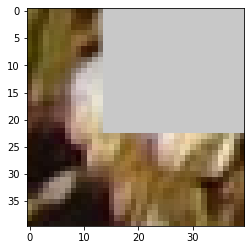

In [227]:
show(X[50])

In [19]:
# Create a dataset using mis-predictions
Predict = True
X = []
Y = []
folders = ["1", "2", "samples"]
# folders = ["samples"]
test_images = ["2019_1010_123350_243.JPG", "2019_1010_123351_244.JPG"]
for folder in folders:
    base_path = path.join(PATH, folder)
    print(base_path)
    ann = pd.read_csv(path.join(base_path, "via_export_csv.csv"))
    for file in ann["filename"].unique():
        if file in test_images:
            continue
#         if file != "2019_1010_123336_234.JPG":
#             continue
#         if file != "2019_1010_123336_234_7_4.jpg":
#             continue
        training_data = []
        print(file)
        
        # Create a list of all 40 40 boxes with 20 stride
        sample_ann = ann[ann["filename"] == file]
        img = cv2.imread(path.join(base_path, file))
        if img is None:
            continue
        for _x in range(0, img.shape[1] - 40, 20):
            for _y in range(0, img.shape[0] - 40, 20):
                xstart = _x
                xend = _x + 40
                ystart = _y
                yend = _y + 40
                training_data.append([ystart, yend, xstart, xend])
        
        cnt = 0
        # Read all the annotations
        for ix, val in sample_ann.iterrows():
            coords = json.loads(val["region_shape_attributes"])
            if "x" not in coords.keys():
                continue
            x1 = coords["x"]
            if x1 is None:
                continue
            x2 = x1 + coords["width"]
            y1 = coords["y"]
            y2 = y1 + coords["height"]
            img_crop = img[y1: y2, x1:x2]
            X.append(cv2.resize(img_crop, (40, 40)))
            Y.append(1)
            X.append(cv2.resize(img_crop, (40, 40)))
            Y.append(1)
            cnt += 1
            
        if cnt == 0:
            continue
        
  
        # Predict all the boxes using the current model
        if Predict:
            all_images = []
            predictions = []
#             for ix in tqdm.tqdm_notebook(range(len(training_data))):
            for ix in range(len(training_data)):
                val = training_data[ix]
                samp_img = img[val[0]: val[1], val[2]: val[3]]
                all_images.append(samp_img)
                if len(all_images) == 50000:
                    all_images = np.array(all_images) * 1.0 / 255
                    temp_predictions = model.predict(all_images, verbose=1).tolist()
                    predictions.extend(temp_predictions)
                    all_images = []
            all_images = np.array(all_images) * 1.0 / 255
            predictions.extend(model.predict(all_images, verbose =0).tolist())
        all_boxes = []
        all_scores = []
        for ix in range(len(predictions)):
            prob = predictions[ix][1]
            if prob > 0.5:
                val = training_data[ix]
                all_boxes.append([val[2], val[0], 40, 40])
                all_scores.append(prob)
        indices = nms.boxes(all_boxes, all_scores, nms_threshold=0.1)

        for ix, val in sample_ann.iterrows():
            coords = json.loads(val["region_shape_attributes"])
            if "x" not in coords.keys():
                continue
            x1 = coords["x"]
            if x1 is None:
                continue
            x2 = x1 + coords["width"]
            y1 = coords["y"]
            y2 = y1 + coords["height"]
            img_crop = img[y1:y2, x1:x2]
            img[y1:y2, x1:x2] = np.ones_like(img_crop)
        imgg = cv2.imread(path.join(base_path, "labels", file))   
        for ix in indices:
            if all_scores[ix] > 0.9:
                x1 = all_boxes[ix][0]
                y1 = all_boxes[ix][1]
                x2 = x1 + 40
                y2 = y1 + 40
                img_crop = img[y1:y2, x1:x2]
#                 print(x1, x2, y1, y2)
                if len(np.where(img_crop==1)[0]) < 100:
#                 if True:
                    X.append(img_crop.copy())
                    Y.append(0)
                    imgg = cv2.rectangle(imgg, (x1, y1), (x2, y2), (0, 255, 0), 2)
                else:
                    imgg = cv2.rectangle(imgg, (x1, y1), (x2, y2), (0, 255, 255), 2)
        if imgg is not None:
            cv2.imwrite(path.join(base_path, "predictions", file), imgg)
            
X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y)

/mnt/d/personal/cotton/1
2019_1010_123203_172.JPG
2019_1010_123204_173.JPG
2019_1010_123206_174.JPG
2019_1010_123207_175.JPG
2019_1010_123209_176.JPG
2019_1010_123210_177.JPG
2019_1010_123212_178.JPG
2019_1010_123213_179.JPG
2019_1010_123215_180.JPG
2019_1010_123216_181.JPG
2019_1010_123218_182.JPG
2019_1010_123219_183.JPG
2019_1010_123221_184.JPG
2019_1010_123222_185.JPG
2019_1010_123224_186.JPG
2019_1010_123225_187.JPG
2019_1010_123227_188.JPG
2019_1010_123228_189.JPG
2019_1010_123230_190.JPG
2019_1010_123237_195.JPG
2019_1010_123239_196.JPG
2019_1010_123240_197.JPG
2019_1010_123242_198.JPG
2019_1010_123243_199.JPG
2019_1010_123245_200.JPG
2019_1010_123247_201.JPG
2019_1010_123248_202.JPG
2019_1010_123250_203.JPG
2019_1010_123251_204.JPG
2019_1010_123253_205.JPG
2019_1010_123254_206.JPG
2019_1010_123256_207.JPG
2019_1010_123257_208.JPG
2019_1010_123259_209.JPG
2019_1010_123300_210.JPG
2019_1010_123302_211.JPG
2019_1010_123303_212.JPG
2019_1010_123305_213.JPG
2019_1010_123306_214.JPG


In [13]:
Y.shape

(28149, 2)

In [14]:
np.count_nonzero(np.argmax(Y, axis=1))

2559

In [536]:
# Runs the model through the sample images and draws a bounding box
do_nms = True
do_prediction = False
prob_thresh = 0.5
stride = 20
base_path = path.join(PATH, "samples")
cnt = 0
ann = pd.read_csv(path.join(base_path, "via_export_csv.csv"))
for file in ann["filename"].unique():
    if file != "2019_1010_123350_243.JPG":
        continue
#     if not file.startswith("2019_1010_123350_243"):
#         continue
    sample_ann = ann[ann["filename"] == file]
    training_data = []
    img = cv2.imread(path.join(base_path, file))
    for _x in range(0, img.shape[1] - 40, stride):
        for _y in range(0, img.shape[0] - 40, stride):
            xstart = _x
            xend = _x + 40
            ystart = _y
            yend = _y + 40
            training_data.append([ystart, yend, xstart, xend])
    
    img = cv2.imread(path.join(base_path, file))
    if do_prediction:
        all_images = []
        predictions = []
        for ix in tqdm.tqdm_notebook(range(len(training_data))):
            val = training_data[ix]
            samp_img = img[val[0]: val[1], val[2]: val[3]]
            all_images.append(samp_img)
            if len(all_images) == 50000:
                all_images = np.array(all_images) * 1.0 / 255
                temp_predictions = model.predict_proba(all_images, verbose=1).tolist()
                predictions.extend(temp_predictions)
                all_images = []
        all_images = np.array(all_images) * 1.0 / 255
        predictions.extend(model.predict_proba(all_images, verbose =1).tolist())

    img = cv2.imread(path.join(base_path, "labels", file))
    all_boxes = []
    all_scores = []
    for ix in range(len(predictions)):
        prob = predictions[ix][1]
        if prob > 0.5:
            val = training_data[ix]
            all_boxes.append([val[2], val[0], 40, 40])
            all_scores.append(prob)
    if do_nms:
        indices = nms.boxes(all_boxes, all_scores, nms_threshold=0.1)
    else:
        indices = range(len(all_boxes))
     
    for ix in indices:
        if all_scores[ix] > prob_thresh:
            cnt += 1
            img = cv2.rectangle(img, (all_boxes[ix][0], all_boxes[ix][1]), (all_boxes[ix][0] + 40, all_boxes[ix][1] + 40), (0, 255, 0), 2)
    cv2.imwrite(path.join(base_path, "predictions", file), img)
    break
print(cnt)

139
